# Проект Определение стоимости автомобилей

## Введение


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.


## Описание данных

### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
### Целевой признак
- Price — цена (евро)

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.svm import SVC, SVR

matplotlib_axes_logger.setLevel('ERROR')
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', -1)


sns.set()

## Загрузка данных

In [61]:
df_cars = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
display(df_cars.head(5))
df_cars.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

По загруженным данным можно сделать следующие выводы:
- размерность датасета 354369 х 16
- датасет содержит как числовые так и категориальные типы данных. Кроме полей которые содержат дату и имеют тип object (DateCrawled, DateCreated, LastSeen), все остальные типы соответствуют своим данным. Типы колонок DateCrawled, DateCreated, LastSeen надо перобразовать в соответствующие типы (date или timestamp)
- в некоторых колонках имеются пропуски

## Предобработка данных

- Колонки DateCrawled, DateCreated, LastSeen приведены к типу datetime64
- Остальные колонки типа object приведены к типу string

In [62]:
df_cars_str_col_list = df_cars.select_dtypes(exclude=np.number).columns
df_cars[df_cars_str_col_list] = df_cars[df_cars_str_col_list].astype('string')

df_cars['DateCrawled'] = pd.to_datetime(df_cars['DateCrawled'])
df_cars['DateCreated'] = pd.to_datetime(df_cars['DateCreated'])
df_cars['LastSeen'] = pd.to_datetime(df_cars['LastSeen'])

df_cars.info()
df_cars.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  string        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  string        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  string        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  string        
 10  Brand              354369 non-null  string        
 11  Repaired           283215 non-null  string        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,<NA>,1993,manual,0,golf,150000,0,petrol,volkswagen,<NA>,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,<NA>,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,<NA>,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Колонка NumberOfPictures содержит значения все равные 0. В связи с этим она признана неинформативной и удалена из датасета

In [63]:
df_cars.describe()
df_cars = df_cars.drop(['NumberOfPictures'], axis = 1)
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  string        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  string        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  string        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  string        
 10  Brand              354369 non-null  string        
 11  Repaired           283215 non-null  string        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

Для того, чтобы предварительно обнаружить дубликаты, надо определить набор аттрибутов на которых надо определять эти дубликаты. Во первых, надо из общего числа аттрибутов убрать целевой признак Price, потом убрать те входные признаки, которые не будут участвовать в работе модели.
На мой взгляд это такие служебные признаки как:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- LastSeen — дата последней активности пользователя

Обнаружено 34565 дубликатов для всех входных аттрибутов (исключая вышеперечисленные). Пока с ними ничего не буду делать, так как далее будет иметь место заполнение пропусков и я посмотрю на дубликаты после этой процедуры.

In [65]:
list_for_duplicates = ["Price", "DateCrawled", "DateCreated", "LastSeen"]
print(f'Количество дубликатов: df_cars: {df_cars.duplicated(subset=df_cars.columns.difference(list_for_duplicates)).sum()}')


Количество дубликатов: df_cars: 34565


Ананлиз данных (метод info()) показал, что пропуски имеют место только в категориальных колонках (кроме колонки Brand) и в связи с этим принято решение заполнить их в пайплайне модой для соответствуующего аттрибута. После этого еще раз провести проверку на дубликаты (без целевого признака Price) и уже после этого удалить имеющиеся дубликаты.

In [66]:
cat_col_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
def display_value_count(df, col_list):
    for c in col_list:
        print(f"------- {c} -------")
        display(df[c].value_counts(dropna = False))

display_value_count(df_cars, cat_col_list)

df_cars.info()

------- VehicleType -------


sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other          3288 
Name: VehicleType, dtype: Int64

------- Gearbox -------


manual    268251
auto      66285 
NaN       19833 
Name: Gearbox, dtype: Int64

------- Model -------


golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
serie_2               8    
serie_3               4    
rangerover            4    
range_rover_evoque    2    
serie_1               2    
Name: Model, Length: 251, dtype: Int64

------- FuelType -------


petrol      216352
gasoline    98720 
NaN         32895 
lpg         5310  
cng         565   
hybrid      233   
other       204   
electric    90    
Name: FuelType, dtype: Int64

------- Brand -------


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat              9643 
seat              6907 
mazda             5615 
skoda             5500 
smart             5246 
citroen           5148 
nissan            4941 
toyota            4606 
hyundai           3587 
sonstige_autos    3374 
volvo             3210 
mini              3202 
mitsubishi        3022 
honda             2817 
kia               2465 
suzuki            2323 
alfa_romeo        2314 
chevrolet         1754 
chrysler          1439 
dacia             900  
daihatsu          806  
subaru            762  
porsche           758  
jeep              677  
trabant           589  
land_rover        545  
daewoo            542  
saab              526  
jaguar            505  
rover             486  
lancia            471  
lada              225  
Name: Brand, dtype: Int64

------- Repaired -------


no     247161
NaN    71154 
yes    36054 
Name: Repaired, dtype: Int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  string        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  string        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  string        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  string        
 10  Brand              354369 non-null  string        
 11  Repaired           283215 non-null  string        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

Использую пайплайн для применения SimpleImputer на этапе предобработки данных. В пайплайне использую SimpleImputer  для замены NaN на моду для колонок из списка cat_col_list с категориальными признаками так как пропуски имеют место только для этих колонок.


In [67]:

df_cars = df_cars.replace({pd.NA: np.nan})
df_cars_dtypes = df_cars.dtypes

X = df_cars.drop(['Price'], axis=1)
y = df_cars['Price']

simple_imp_pipeline = Pipeline(
    [
        (
            'simpleImputer_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('simple_imp_pipeline', simple_imp_pipeline, X.columns)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor)
    ]
)


df_cars_arr = pipe_final.fit_transform(X)
df_cars = pd.concat([pd.DataFrame(df_cars_arr, columns = X.columns),y], axis=1)
for col in df_cars.columns:
  df_cars[col] = df_cars[col].astype(df_cars_dtypes[col])
display_value_count(df_cars, cat_col_list)
df_cars.info()

------- VehicleType -------


sedan          128947
small          79831 
wagon          65166 
bus            28775 
convertible    20203 
coupe          16163 
suv            11996 
other          3288  
Name: VehicleType, dtype: int64

------- Gearbox -------


manual    288084
auto      66285 
Name: Gearbox, dtype: int64

------- Model -------


golf                  48937
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2               8    
serie_3               4    
rangerover            4    
range_rover_evoque    2    
serie_1               2    
Name: Model, Length: 250, dtype: int64

------- FuelType -------


petrol      249247
gasoline    98720 
lpg         5310  
cng         565   
hybrid      233   
other       204   
electric    90    
Name: FuelType, dtype: int64

------- Brand -------


volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat              9643 
seat              6907 
mazda             5615 
skoda             5500 
smart             5246 
citroen           5148 
nissan            4941 
toyota            4606 
hyundai           3587 
sonstige_autos    3374 
volvo             3210 
mini              3202 
mitsubishi        3022 
honda             2817 
kia               2465 
suzuki            2323 
alfa_romeo        2314 
chevrolet         1754 
chrysler          1439 
dacia             900  
daihatsu          806  
subaru            762  
porsche           758  
jeep              677  
trabant           589  
land_rover        545  
daewoo            542  
saab              526  
jaguar            505  
rover             486  
lancia            471  
lada              225  
Name: Brand, dtype: Int64

------- Repaired -------


no     318315
yes    36054 
Name: Repaired, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   VehicleType        354369 non-null  object        
 2   RegistrationYear   354369 non-null  int64         
 3   Gearbox            354369 non-null  object        
 4   Power              354369 non-null  int64         
 5   Model              354369 non-null  object        
 6   Kilometer          354369 non-null  int64         
 7   RegistrationMonth  354369 non-null  int64         
 8   FuelType           354369 non-null  object        
 9   Brand              354369 non-null  string        
 10  Repaired           354369 non-null  object        
 11  DateCreated        354369 non-null  datetime64[ns]
 12  PostalCode         354369 non-null  int64         
 13  LastSeen           354369 non-null  datetime

После замены пропусков на моду еще раз проверил количество дубликатов и их число теперь равно 40351. Удаляю эти дубликаты. Если позже придется в рамках исправления возможных аномалий и выбросов заменять их на какие либо значения для определенных колонок - то процедуру проверки и удаления дубликатов на этом же множестве аттрибутов надо повторить.

In [68]:
print(f'Количество дубликатов: df_cars: {df_cars.duplicated(subset=df_cars.columns.difference(list_for_duplicates)).sum()}')
df_cars = df_cars.drop_duplicates(subset=df_cars.columns.difference(list_for_duplicates))
print(f'Количество дубликатов: df_cars: {df_cars.duplicated(subset=df_cars.columns.difference(list_for_duplicates)).sum()}')

Количество дубликатов: df_cars: 40351
Количество дубликатов: df_cars: 0


In [69]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314018 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        314018 non-null  datetime64[ns]
 1   VehicleType        314018 non-null  object        
 2   RegistrationYear   314018 non-null  int64         
 3   Gearbox            314018 non-null  object        
 4   Power              314018 non-null  int64         
 5   Model              314018 non-null  object        
 6   Kilometer          314018 non-null  int64         
 7   RegistrationMonth  314018 non-null  int64         
 8   FuelType           314018 non-null  object        
 9   Brand              314018 non-null  string        
 10  Repaired           314018 non-null  object        
 11  DateCreated        314018 non-null  datetime64[ns]
 12  PostalCode         314018 non-null  int64         
 13  LastSeen           314018 non-null  datetime

## Исследовательский анализ данных

In [36]:
int_to_string_col_list = ['Power', 'RegistrationMonth', 'PostalCode', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
#df_cars.info()
df_cars[int_to_string_col_list] = df_cars[int_to_string_col_list].astype('string')
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354363 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354363 non-null  datetime64[ns]
 1   VehicleType        354363 non-null  string        
 2   RegistrationYear   354363 non-null  int64         
 3   Gearbox            354363 non-null  string        
 4   Power              354363 non-null  string        
 5   Model              354363 non-null  string        
 6   Kilometer          354363 non-null  int64         
 7   RegistrationMonth  354363 non-null  string        
 8   FuelType           354363 non-null  string        
 9   Brand              354363 non-null  string        
 10  Repaired           354363 non-null  string        
 11  DateCreated        354363 non-null  datetime64[ns]
 12  PostalCode         354363 non-null  string        
 13  LastSeen           354363 non-null  datetime

In [11]:
display_value_count(df_cars, df_cars.drop(['Price'], axis=1).select_dtypes(exclude=np.number).columns)

------- DateCrawled -------


2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-03-07 17:36:19    5
2016-03-23 13:50:19    5
                      ..
2016-03-25 15:54:08    1
2016-03-21 11:45:06    1
2016-03-26 19:50:40    1
2016-03-17 09:50:45    1
2016-03-10 16:49:49    1
Name: DateCrawled, Length: 271174, dtype: int64

------- VehicleType -------


sedan          128945
small          79830 
wagon          65165 
bus            28775 
convertible    20203 
coupe          16161 
suv            11996 
other          3288  
Name: VehicleType, dtype: int64

------- RegistrationYear -------


2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
3800    1    
3700    1    
9229    1    
1602    1    
2900    1    
Name: RegistrationYear, Length: 151, dtype: Int64

------- Gearbox -------


manual    288080
auto      66283 
Name: Gearbox, dtype: int64

------- Power -------


0        40225
75       24022
60       15897
150      14590
101      13298
         ...  
17700    1    
2729     1    
1351     1    
1149     1    
460      1    
Name: Power, Length: 712, dtype: Int64

------- Model -------


golf                  48936
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2               8    
serie_3               4    
rangerover            4    
range_rover_evoque    2    
serie_1               2    
Name: Model, Length: 250, dtype: int64

------- RegistrationMonth -------


0     37352
3     34373
6     31507
4     29270
5     29153
7     27211
10    26099
12    24288
11    24186
9     23812
1     23218
8     22627
2     21267
Name: RegistrationMonth, dtype: Int64

------- FuelType -------


petrol      249243
gasoline    98718 
lpg         5310  
cng         565   
hybrid      233   
other       204   
electric    90    
Name: FuelType, dtype: int64

------- Brand -------


volkswagen        77011
opel              39931
bmw               36914
mercedes_benz     32044
audi              29455
ford              25179
renault           17927
peugeot           10998
fiat              9643 
seat              6907 
mazda             5615 
skoda             5500 
smart             5246 
citroen           5148 
nissan            4941 
toyota            4606 
hyundai           3587 
sonstige_autos    3374 
volvo             3210 
mini              3202 
mitsubishi        3022 
honda             2817 
kia               2465 
suzuki            2322 
alfa_romeo        2314 
chevrolet         1754 
chrysler          1439 
dacia             900  
daihatsu          806  
subaru            762  
porsche           758  
jeep              677  
trabant           589  
land_rover        545  
daewoo            542  
saab              526  
jaguar            505  
rover             486  
lancia            471  
lada              225  
Name: Brand, dtype: Int64

------- Repaired -------


no     318310
yes    36053 
Name: Repaired, dtype: int64

------- DateCreated -------


2016-04-03    13718
2016-04-04    13316
2016-03-20    12918
2016-03-12    12840
2016-03-21    12691
              ...  
2015-11-10    1    
2016-01-06    1    
2015-03-20    1    
2015-06-18    1    
2015-11-12    1    
Name: DateCreated, Length: 109, dtype: int64

------- PostalCode -------


10115    819
65428    612
66333    343
32257    317
44145    317
        ... 
74937    1  
79695    1  
21784    1  
6725     1  
82279    1  
Name: PostalCode, Length: 8143, dtype: Int64

------- LastSeen -------


2016-04-06 13:45:54    17
2016-04-07 13:17:48    16
2016-04-07 00:45:17    16
2016-04-06 12:15:45    16
2016-04-07 09:44:27    16
                       ..
2016-04-05 01:17:39    1 
2016-04-04 05:45:07    1 
2016-04-03 13:53:16    1 
2016-03-31 20:44:11    1 
2016-04-05 11:44:39    1 
Name: LastSeen, Length: 179150, dtype: int64

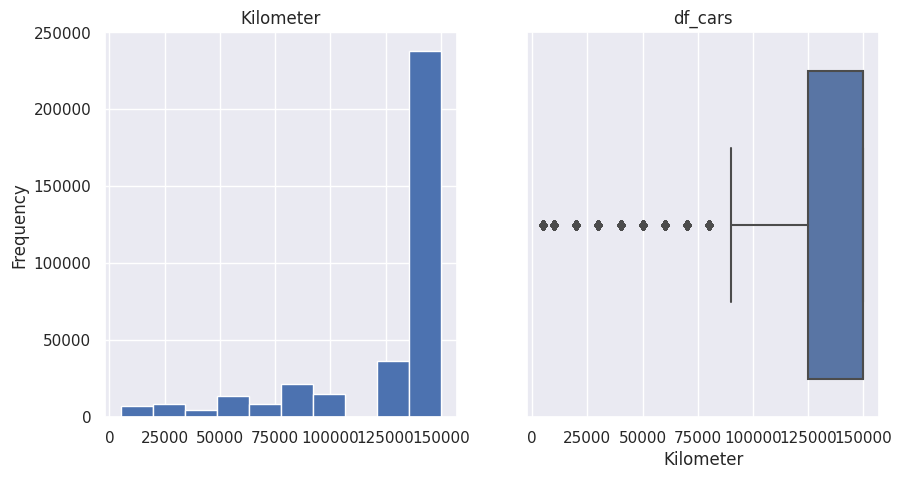

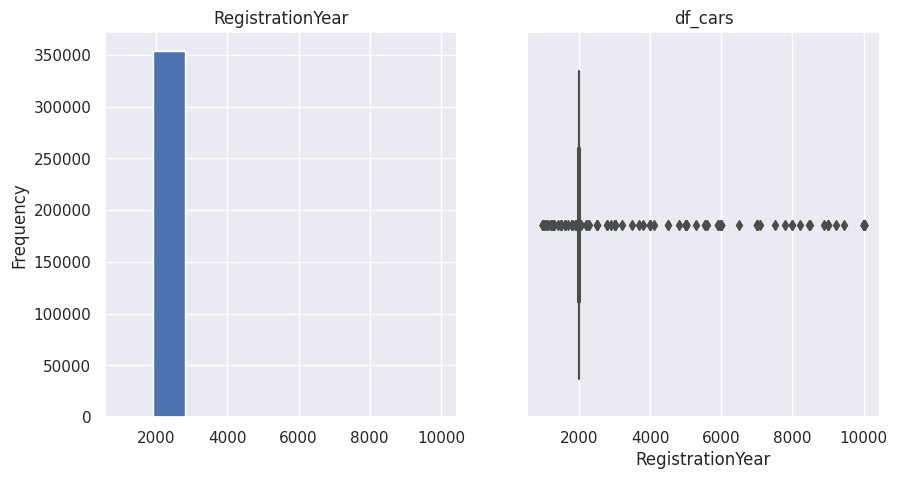

TypeError: The DType <class 'numpy._IntegerAbstractDType'> could not be promoted by <class 'numpy.dtype[datetime64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy._IntegerAbstractDType'>, <class 'numpy._IntegerAbstractDType'>, <class 'numpy.dtype[datetime64]'>)

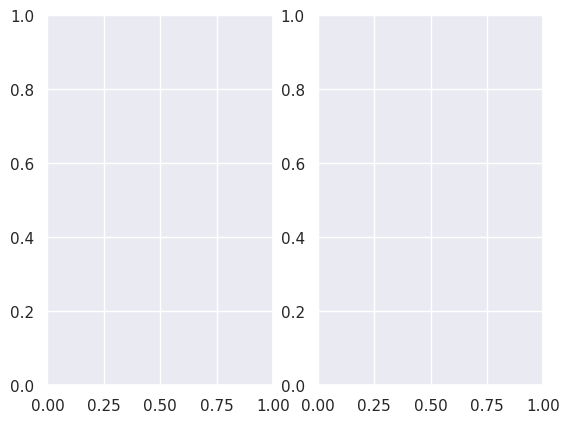

In [38]:
def plot_sub_plot_hist_boxplot(df, col_list, title):
    for col in col_list:
        if col == 'id':
            continue
        fig, axes = plt.subplots(nrows=1, ncols=2)
        df[col].plot(kind="hist", title=col, figsize=(10, 5), ax = axes[0])
        sns.boxplot(df[col], ax = axes[1])
        plt.title(title)
        plt.show()

def plot_pie_plot_for_columns(df, title):
    for col in df.columns:
        df[col].value_counts().plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, figsize=(5,5), title=col);
        plt.title(f'{title} for {col}')
        plt.show()

def plot_bar_plot_for_columns(df, col_list, title, normalizer = 1):
    for col in col_list:
        print(col)
        ax = df[col].value_counts().plot(kind='bar',  label='',  figsize=(5,5), title=col);
        plt.title(f'{title} for {col}')
        if normalizer != 1:
          vals = ax.get_yticks()
          ax.set_yticklabels(['{:,.0%}'.format(x / normalizer) for x in vals])
        plt.show()

plot_sub_plot_hist_boxplot(df_cars, ['Kilometer', 'RegistrationYear'], 'df_cars')
#plot_bar_plot_for_columns(df_cars.drop(['Price'], axis=1).select_dtypes(exclude=np.number), 'df_cars')
#col_list =  ['Brand', 'VehicleType', 'RegistrationYear', 'Power', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired', 'PostalCode']
#plot_bar_plot_for_columns(df_cars, col_list, 'df_cars')




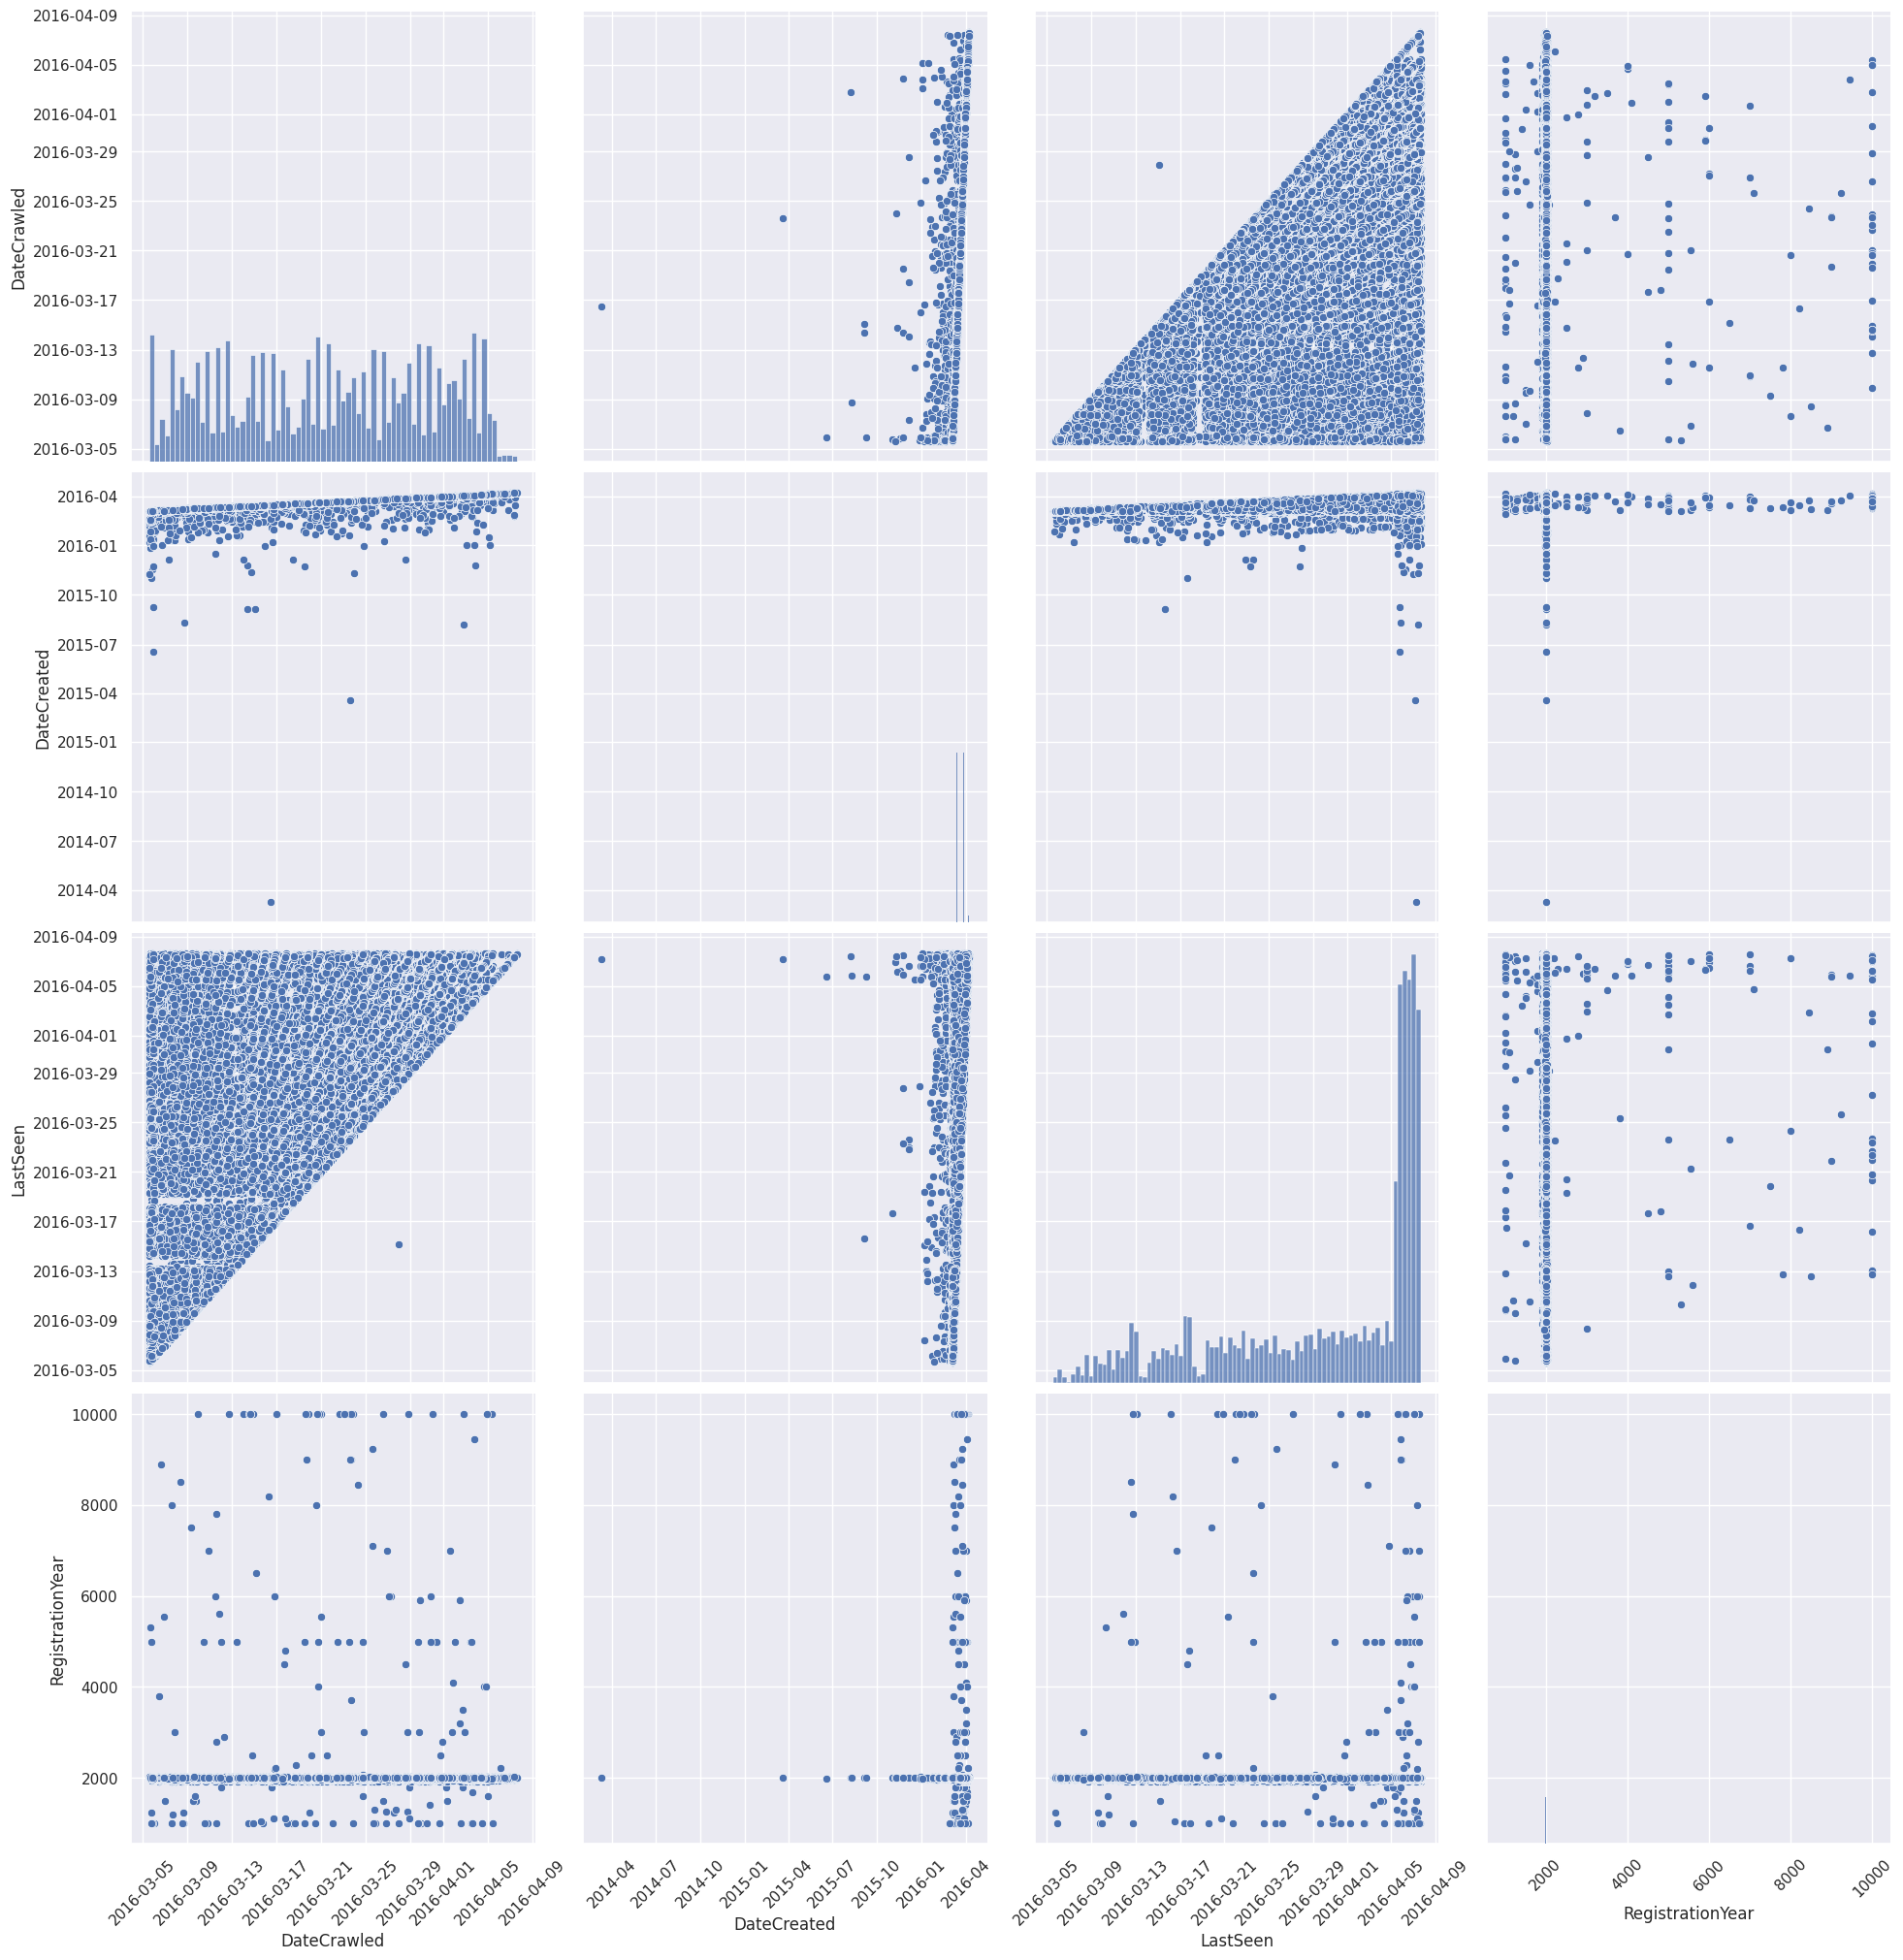

In [59]:
#df_cars.loc[:,['DateCrawled', 'DateCreated', 'LastSeen']]

date_col_list = ['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationYear']

g = sns.pairplot(data = df_cars, vars = date_col_list, height=5)

for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=45)